# Description

In [2]:
# TODO(Paul): consider merging (or factoring out common code) with the `Master_research_backtest_analyzer` and `Master_execution_analysis`.

The notebook:
   - Loads results of a historical simulation
   - Computes research portfolio
   - Saves trades and pnl to a file
   - Performs prices and pnl cross-checks
    
The code overlaps with that from:
   - the `dataflow/model/notebooks/Master_research_backtest_analyzer.ipynb`: load tiled simulation, compute research pnl
   - the `oms/notebooks/Master_execution_analysis.ipynb`: load and resmaple OHLCV prices
        
What is really unique in the current notebook is:
   - Converting `holdings_shares` to `target_holdings_shares`
   - Saving data to a file
   - Prices and pnl cross-checks

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime
import logging
import os

import pandas as pd

import core.config as cconfig
import core.finance as cofinanc
import core.plotting as coplotti
import dataflow.model as dtfmod
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hgit as hgit
import helpers.hpandas as hpandas
import helpers.hparquet as hparque
import helpers.hprint as hprint
import helpers.hsql as hsql
import im_v2.common.universe as ivcu
# TODO(Grisha): probably `dataflow/model` should not depend on `oms`.
import oms.ccxt.ccxt_utils as occccuti

/app/amp/core/signal_processing/decorrelation.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-adb7bc8b-2efe-4abb-bfb9-375b9ecf6106.json'
-----------------------------------------------------------------------------
This code is not in sync with the container:
code_version='1.4.2' != container_version='1.4.0'
-----------------------------------------------------------------------------
You need to:
- merge origin/master into your branch with `invoke git_merge_master`
- pull the latest container with `invoke docker_pull`
INFO  # Git
  branch_name='CmTask4579_save_pnl_and_trades'
  hash='5ac7d0a05'
  # Last commits:
    * 5ac7d0a05 PomazkinG checkpoint                                                        (    3 days ago) Fri Jun 16 14:27:19 2023  (HEAD -> CmTask4579_save_pnl_and_trades, origin/CmTask4579_save_pnl_and_trades)
    * b5bb81621 Toma Jordania Cm task4547 read back data from run ccxt broker v2.py (#4553)     (    4 days ago) Thu Jun 15 11:20:19 2023       

# Build the config

In [4]:
market_info = occccuti.load_market_data_info()
asset_id_to_share_decimals = occccuti.subset_market_info(
    market_info, "amount_precision"
)
asset_id_to_share_decimals

{6051632686: 0,
 8717633868: 0,
 2540896331: 0,
 1528092593: 0,
 8968126878: 2,
 1467591036: 3,
 2476706208: 1,
 5115052901: 0,
 3065029174: 0,
 1891737434: 1,
 3401245610: 1,
 1464553467: 3,
 1966583502: 0,
 1030828978: 0,
 2601760471: 2,
 2683705052: 0,
 9872743573: 0,
 2484635488: 0,
 2099673105: 0,
 4516629366: 0,
 2237530510: 0,
 2425308589: 0,
 1776791608: 1,
 2384892553: 1,
 5118394986: 1}

In [32]:
config = {
    "dir_name": "/shared_data/model/historical/build_tile_configs.C3a.ccxt_v7_1-all.5T.2019-10-01_2023-06-15.ins/tiled_results",
    "start_date": datetime.date(2022, 1, 1),
    "end_date": datetime.date(2023, 3, 31),
    "asset_id_col": "asset_id",
    "pnl_resampling_frequency": "D",
    "annotate_forecasts_kwargs": {
            "burn_in_bars": 3,
            "style": "cross_sectional",
            # Apply asset-specific rounding.
            "quantization": "asset_specific",
            "liquidate_at_end_of_day": False,
            "initialize_beginning_of_day_trades_to_zero": False,
            "asset_id_to_share_decimals": asset_id_to_share_decimals,
        },
    # TODO(Grisha): consider inferring column names from a `DagBuilder` object.
    "column_names": {
        "price_col": "vwap",
        "volatility_col": "garman_klass_vol",
        "prediction_col": "feature",
    },
}
config = cconfig.Config().from_dict(config)
print(config)

dir_name: /shared_data/model/historical/build_tile_configs.C3a.ccxt_v7_1-all.5T.2019-10-01_2023-06-15.ins/tiled_results
start_date: 2022-01-01
end_date: 2023-03-31
asset_id_col: asset_id
pnl_resampling_frequency: D
annotate_forecasts_kwargs: 
  burn_in_bars: 3
  style: cross_sectional
  quantization: asset_specific
  liquidate_at_end_of_day: False
  initialize_beginning_of_day_trades_to_zero: False
  asset_id_to_share_decimals: 
    6051632686: 0
    8717633868: 0
    2540896331: 0
    1528092593: 0
    8968126878: 2
    1467591036: 3
    2476706208: 1
    5115052901: 0
    3065029174: 0
    1891737434: 1
    3401245610: 1
    1464553467: 3
    1966583502: 0
    1030828978: 0
    2601760471: 2
    2683705052: 0
    9872743573: 0
    2484635488: 0
    2099673105: 0
    4516629366: 0
    2237530510: 0
    2425308589: 0
    1776791608: 1
    2384892553: 1
    5118394986: 1
column_names: 
  price_col: vwap
  volatility_col: garman_klass_vol
  prediction_col: feature


# Load tiled results

## Report tile stats

In [6]:
parquet_tile_analyzer = dtfmod.ParquetTileAnalyzer()
parquet_tile_metadata = parquet_tile_analyzer.collate_parquet_tile_metadata(
    config["dir_name"]
)

In [7]:
parquet_tile_analyzer.compute_metadata_stats_by_asset_id(parquet_tile_metadata)

,n_years,n_unique_months,n_files,size
asset_id,,,,
1030828978,2,12,16,11.6 MB
1464553467,5,12,44,35.7 MB
1467591036,5,12,45,39.0 MB
1528092593,3,12,26,18.3 MB
1776791608,3,12,29,21.1 MB
1891737434,4,12,35,26.1 MB
1966583502,4,12,34,27.5 MB
2099673105,4,12,34,24.3 MB
2237530510,4,12,34,26.7 MB


In [8]:
parquet_tile_analyzer.compute_universe_size_by_time(parquet_tile_metadata)

n_asset_ids      size
year month                       
2019 10               1  920.2 KB
     11               2  981.6 KB
     12               2    1.6 MB
2020 1                4    2.5 MB
     2                5    3.5 MB
     3                5    4.0 MB
     4                5    3.7 MB
     5                5    3.7 MB
     6                5    3.5 MB
     7                6    4.4 MB
     8                8    5.5 MB
     9               14    8.8 MB
     10              16   11.5 MB
     11              18   13.2 MB
     12              18   14.7 MB
2021 1               19   15.9 MB
     2               20   16.0 MB
     3               20   18.2 MB
     4               21   18.7 MB
     5               22   19.3 MB
     6               22   18.1 MB
     7               22   18.1 MB
     8               22   18.7 MB
     9               23   18.8 MB
     10              23   19.4 MB
     11              23   19.0 MB
     12              23   19.3 MB
2022 1               23   19.1 MB
     2               23   16.6 MB
     3               25   19.2 MB
     4               25   19.5 MB
     5               25   19.9 MB
     6               25   18.6 MB
     7               25   18.7 MB
     8               25   18.6 MB
     9               25   17.1 MB
     10              25   17.0 MB
     11              25   17.9 MB
     12              25   17.1 MB
2023 1               25   18.7 MB
     2               25   16.7 MB
     3               25   18.3 MB
     4               25   17.3 MB
     5               25   16.9 MB
     6               25    8.2 MB

In [9]:
asset_ids = parquet_tile_metadata.index.levels[0].to_list()
display(asset_ids)

[1030828978,
 1464553467,
 1467591036,
 1528092593,
 1776791608,
 1891737434,
 1966583502,
 2099673105,
 2237530510,
 2384892553,
 2425308589,
 2476706208,
 2484635488,
 2540896331,
 2601760471,
 2683705052,
 3065029174,
 3401245610,
 4516629366,
 5115052901,
 5118394986,
 6051632686,
 8717633868,
 8968126878,
 9872743573]

## Load a single-asset tile

In [10]:
asset_batch_size = 1
cols = None
single_asset_tile = next(
    hparque.yield_parquet_tiles_by_assets(
        config["dir_name"],
        asset_ids[0:1],
        config["asset_id_col"],
        asset_batch_size,
        cols,
    )
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
single_tile_df = dtfmod.process_parquet_read_df(
    single_asset_tile, config["asset_id_col"]
)

In [12]:
single_tile_df.columns.levels[0]

Index(['close', 'close_vol', 'cmf', 'feature', 'garman_klass_vol', 'high', 'low', 'month', 'open', 'parkinson_vol', 'twap', 'volume', 'vwap', 'year'], dtype='object')

In [13]:
single_tile_df.head(3)

,close,close_vol,cmf,feature,garman_klass_vol,high,low,month,open,parkinson_vol,twap,volume,vwap,year
asset_id,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978
end_ts,,,,,,,,,,,,,,
2022-03-15 04:05:00+00:00,0.32974,NaN,0.127181,-0.127181,0.051465,0.33431,0.31000,3,0.32230,0.045340,0.323994,1710307.0,0.326079,2022
2022-03-15 04:10:00+00:00,0.32690,0.008650,0.117903,-0.117903,0.013215,0.33072,0.32432,3,0.32903,0.011736,0.327388,1344264.0,0.327638,2022
2022-03-15 04:15:00+00:00,0.32569,0.003708,-0.548659,0.548659,0.005931,0.32724,0.32440,3,0.32657,0.005235,0.325566,505779.0,0.325527,2022


# Compute portfolio bar metrics

In [14]:
fep = dtfmod.ForecastEvaluatorFromPrices(
    **config["column_names"],
)

In [15]:
# Create backtest dataframe tile iterator.
backtest_df_iter = dtfmod.yield_processed_parquet_tiles_by_year(
    config["dir_name"],
    config["start_date"],
    config["end_date"],
    config["asset_id_col"],
    data_cols=fep.get_cols(),
    asset_ids=None,
)
# Process the dataframes in the interator.
bar_metrics = []
portfolio_dfs = []
for df in backtest_df_iter:
    portfolio_df, bar_metrics_slice = fep.annotate_forecasts(
        df,
        # bulk_frac_to_remove=fep_config["bulk_frac_to_remove"],
        # bulk_fill_method=fep_config["bulk_fill_method"],
        # target_gmv=fep_config["target_gmv"],
        **config["annotate_forecasts_kwargs"].to_dict(),
    )
    bar_metrics.append(bar_metrics_slice)
    portfolio_dfs.append(portfolio_df)
portfolio_df = pd.concat(portfolio_dfs)
bar_metrics = pd.concat(bar_metrics)

  0%|          | 0/2 [00:00<?, ?it/s]

/venv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2583: UserWarning: n_quantiles (1001) is greater than the total number of samples (25). n_quantiles is set to n_samples.
  warnings.warn(
/venv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2583: UserWarning: n_quantiles (1001) is greater than the total number of samples (25). n_quantiles is set to n_samples.
  warnings.warn(


In [16]:
portfolio_df.tail(3)

price                                                                                                                                                                                                                                                                               volatility                                                                                                                                                                                                                                                                         prediction                                                                                                                                                                                                                                                                         holdings_shares                                                                                                                           \
asset_id                  1030828978   1464553467    1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868  8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573      1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208   
end_ts                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
2023-03-31 23:45:00+00:00   0.393482  1822.237994  28479.075128   0.194548   4.949928   6.333551   0.477220   1.432905  21.208939   2.112738   0.388183   0.938361   0.119426   8.392152   7.593827   1.118987   0.077176   2.508512   0.628061   0.836289   0.539017   4.175305  17.692860  316.661494   1.994472   0.002197   0.000847   0.001087   0.001419   0.001556   0.001045   0.003401   0.000886   0.002507   0.000965   0.002363   0.002709   0.001439   0.001031   0.001521   0.001806   0.002046   0.001884   0.001642   0.000865   0.001676   0.001204   0.001268   0.000669   0.002326   0.627817   0.333556   0.204040  -0.250037   0.442212   0.124017   0.068729   0.590790   0.111765  -0.161155  -0.052216   0.155501   0.048460   0.628028   0.601989   0.255142  -0.024161   0.240934   0.282810   0.853611   0.331204   0.000615   0.411286  -0.088507   0.658223        -34164.0     48.363      2.743    19111.0    23922.7     3686.6    -8572.0    10216.0    -1179.0   -10942.4   -12094.0  -117787.4   
2023-03-31 23:50:00+00:00   0.393421  1822.

In [17]:
bar_metrics.tail(3)

,pnl,gross_volume,net_volume,gmv,nmv
end_ts,,,,,
2023-03-31 23:45:00+00:00,-434.254569,1.117278e+06,209138.341285,9.989635e+05,345830.702750
2023-03-31 23:50:00+00:00,134.003655,1.119395e+06,-326658.691748,1.000088e+06,19306.014658
2023-03-31 23:55:00+00:00,-43.310920,1.380740e+06,-37838.661493,9.994848e+05,-18575.957756


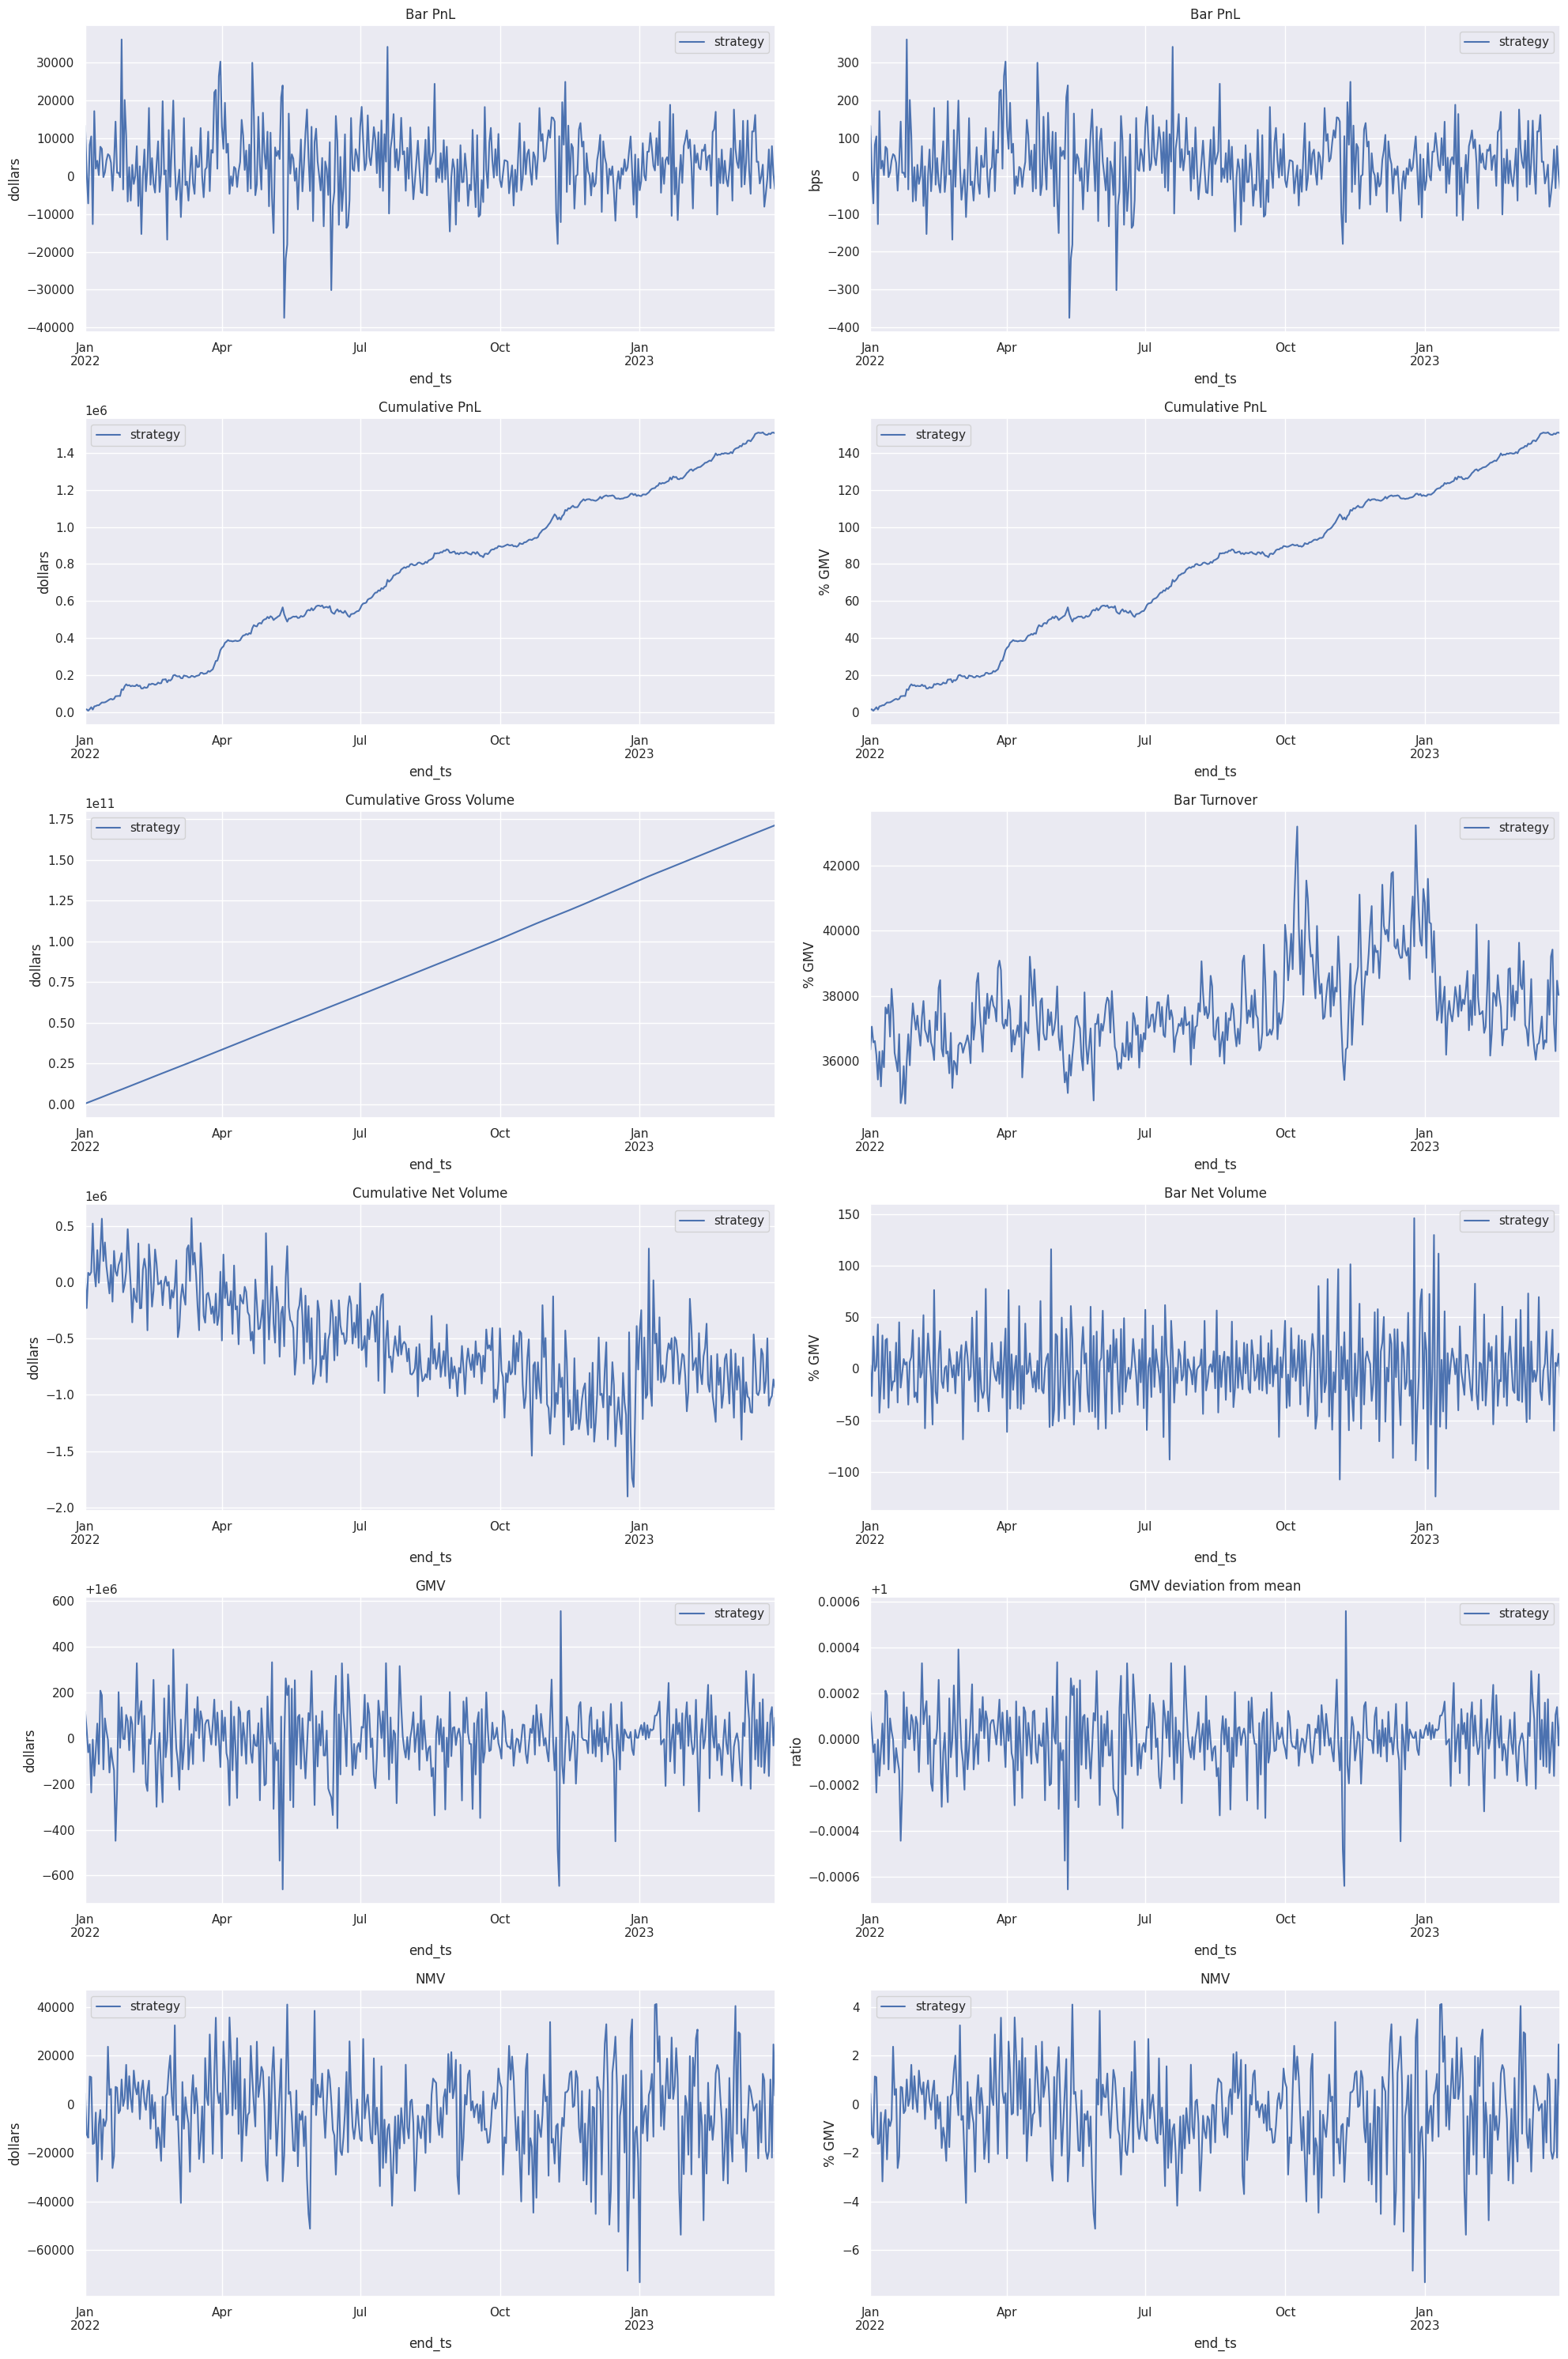

In [18]:
coplotti.plot_portfolio_stats(
    bar_metrics, freq=config["pnl_resampling_frequency"]
)

# Sanity check portfolio

In [19]:
# Check that the PnL is computed correctly by computing it in different ways
# and comparing to the reference one.
# Use the smallest correlation accross instruments to detect an error.
dtfmod.cross_check_portfolio_pnl(portfolio_df).min()

reference_pnl                                   1.0
holdings_notional_diff_minus_trades_notional    1.0
holdings_times_price_diff                       1.0
holdings_notional_minus_trade_times_price       1.0
holdings_notional_times_pct_price_change        1.0
dtype: float64

# Load the asset ids to full symbols mapping

In [20]:
vendor = "CCXT"
mode = "trade"
full_symbols = ivcu.get_vendor_universe(vendor, mode, version="v7.1", as_full_symbol=True)
asset_id_to_full_symbol = ivcu.build_numerical_to_string_id_mapping(
    full_symbols
)
asset_id_to_full_symbol

{6051632686: 'binance::APE_USDT',
 8717633868: 'binance::AVAX_USDT',
 2540896331: 'binance::AXS_USDT',
 1528092593: 'binance::BAKE_USDT',
 8968126878: 'binance::BNB_USDT',
 1467591036: 'binance::BTC_USDT',
 2476706208: 'binance::CRV_USDT',
 5115052901: 'binance::CTK_USDT',
 3065029174: 'binance::DOGE_USDT',
 1891737434: 'binance::DOT_USDT',
 3401245610: 'binance::DYDX_USDT',
 1464553467: 'binance::ETH_USDT',
 1966583502: 'binance::FTM_USDT',
 1030828978: 'binance::GMT_USDT',
 2601760471: 'binance::LINK_USDT',
 2683705052: 'binance::MATIC_USDT',
 9872743573: 'binance::NEAR_USDT',
 2484635488: 'binance::OGN_USDT',
 2099673105: 'binance::RUNE_USDT',
 4516629366: 'binance::SAND_USDT',
 2237530510: 'binance::SOL_USDT',
 2425308589: 'binance::STORJ_USDT',
 1776791608: 'binance::UNFI_USDT',
 2384892553: 'binance::WAVES_USDT',
 5118394986: 'binance::XRP_USDT'}

# Save target holdings shares

In [21]:
# Target holdings are current holdings shifted back by 1 bar. E.g., `target_holdings_shares` computed at 23:50 is
# the holdings that Binance will observe at 23:55.
target_holdings_shares = portfolio_df["holdings_shares"].shift(-1).stack().reset_index()
# Mapp asset ids to fulls symbols.
target_holdings_shares["full_symbol"] = target_holdings_shares["asset_id"].apply(lambda x: asset_id_to_full_symbol[x])
# Rename the column.
target_holdings_shares = target_holdings_shares.rename(columns={0: 'target_holdings_shares'})
# Keep only the relevant columns.
target_holdings_shares = target_holdings_shares[["end_ts", "full_symbol", "target_holdings_shares"]]
_LOG.info("df.shape=%s", target_holdings_shares.shape)
target_holdings_shares.tail(10)

INFO  df.shape=(3232700, 3)


,end_ts,full_symbol,target_holdings_shares
3232690,2023-03-31 23:50:00+00:00,binance::MATIC_USDT,21951.0
3232691,2023-03-31 23:50:00+00:00,binance::DOGE_USDT,864888.0
3232692,2023-03-31 23:50:00+00:00,binance::DYDX_USDT,5731.2
3232693,2023-03-31 23:50:00+00:00,binance::SAND_USDT,108223.0
3232694,2023-03-31 23:50:00+00:00,binance::CTK_USDT,-31708.0
3232695,2023-03-31 23:50:00+00:00,binance::XRP_USDT,16640.8
3232696,2023-03-31 23:50:00+00:00,binance::APE_USDT,-2844.0
3232697,2023-03-31 23:50:00+00:00,binance::AVAX_USDT,-4586.0
3232698,2023-03-31 23:50:00+00:00,binance::BNB_USDT,480.9
3232699,2023-03-31 23:50:00+00:00,binance::NEAR_USDT,12137.0


In [22]:
target_holdings_shares_path = "/shared_data/marketing/vip9_binance/target_holdings_shares.csv.gz"
target_holdings_shares.to_csv(target_holdings_shares_path, index=False)

In [23]:
tmp = pd.read_csv(target_holdings_shares_path)
_LOG.info("df.shape=%s", tmp.shape)
tmp.tail(10)

INFO  df.shape=(3232700, 3)


,end_ts,full_symbol,target_holdings_shares
3232690,2023-03-31 23:50:00+00:00,binance::MATIC_USDT,21951.0
3232691,2023-03-31 23:50:00+00:00,binance::DOGE_USDT,864888.0
3232692,2023-03-31 23:50:00+00:00,binance::DYDX_USDT,5731.2
3232693,2023-03-31 23:50:00+00:00,binance::SAND_USDT,108223.0
3232694,2023-03-31 23:50:00+00:00,binance::CTK_USDT,-31708.0
3232695,2023-03-31 23:50:00+00:00,binance::XRP_USDT,16640.8
3232696,2023-03-31 23:50:00+00:00,binance::APE_USDT,-2844.0
3232697,2023-03-31 23:50:00+00:00,binance::AVAX_USDT,-4586.0
3232698,2023-03-31 23:50:00+00:00,binance::BNB_USDT,480.9
3232699,2023-03-31 23:50:00+00:00,binance::NEAR_USDT,12137.0


# Save PnL

In [24]:
pnl_df = portfolio_df["pnl"].stack().reset_index()
# Mapp asset ids to fulls symbols.
pnl_df["full_symbol"] = pnl_df["asset_id"].apply(lambda x: asset_id_to_full_symbol[x])
# Rename.
pnl_df = pnl_df.rename(columns={0: 'pnl'})
# Keep only the relevant columns.
pnl_df = pnl_df[["end_ts", "full_symbol", "pnl"]]
_LOG.info("df.shape=%s", pnl_df.shape)
pnl_df.tail(10)

INFO  df.shape=(3232700, 3)


,end_ts,full_symbol,pnl
3232690,2023-03-31 23:55:00+00:00,binance::MATIC_USDT,-5.955796
3232691,2023-03-31 23:55:00+00:00,binance::DOGE_USDT,36.411326
3232692,2023-03-31 23:55:00+00:00,binance::DYDX_USDT,0.000000
3232693,2023-03-31 23:55:00+00:00,binance::SAND_USDT,-22.616395
3232694,2023-03-31 23:55:00+00:00,binance::CTK_USDT,67.517205
3232695,2023-03-31 23:55:00+00:00,binance::XRP_USDT,-51.707788
3232696,2023-03-31 23:55:00+00:00,binance::APE_USDT,-7.043253
3232697,2023-03-31 23:55:00+00:00,binance::AVAX_USDT,22.773658
3232698,2023-03-31 23:55:00+00:00,binance::BNB_USDT,-12.053475
3232699,2023-03-31 23:55:00+00:00,binance::NEAR_USDT,-27.462444


In [25]:
pnl_path = "/shared_data/marketing/vip9_binance/pnl.csv.gz"
pnl_df.to_csv(pnl_path, index=False)

In [26]:
tmp = pd.read_csv(pnl_path)
_LOG.info("df.shape=%s", tmp.shape)
tmp.tail(10)

INFO  df.shape=(3232700, 3)


,end_ts,full_symbol,pnl
3232690,2023-03-31 23:55:00+00:00,binance::MATIC_USDT,-5.955796
3232691,2023-03-31 23:55:00+00:00,binance::DOGE_USDT,36.411326
3232692,2023-03-31 23:55:00+00:00,binance::DYDX_USDT,0.000000
3232693,2023-03-31 23:55:00+00:00,binance::SAND_USDT,-22.616395
3232694,2023-03-31 23:55:00+00:00,binance::CTK_USDT,67.517205
3232695,2023-03-31 23:55:00+00:00,binance::XRP_USDT,-51.707788
3232696,2023-03-31 23:55:00+00:00,binance::APE_USDT,-7.043253
3232697,2023-03-31 23:55:00+00:00,binance::AVAX_USDT,22.773658
3232698,2023-03-31 23:55:00+00:00,binance::BNB_USDT,-12.053475
3232699,2023-03-31 23:55:00+00:00,binance::NEAR_USDT,-27.462444


# Sanity check PnL vs target positions

In [27]:
import dataflow_amp.system.Cx as dtfamsysc
import market_data as mdata
import dataflow.system as dtfsys
import dataflow.core as dtfcore

def _get_prod_market_data(universe_version: str) -> mdata.MarketData:
    """
    Get `MarketData` backed by the realtime prod DB.

    :param universe version: universe version, e.g., "v7.1."
    """
    # Get trading universe as asset ids.
    vendor = "CCXT"
    mode = "trade"
    as_full_symbol = True
    full_symbols = ivcu.get_vendor_universe(
        vendor,
        mode,
        version=universe_version,
        as_full_symbol=as_full_symbol,
    )
    asset_ids = [
        ivcu.string_to_numerical_id(full_symbol) for full_symbol in full_symbols
    ]
    # TODO(Grisha): consider creating `get_Cx_RealTimeMarketData_prod_instance2()`
    # with `vendor`, `mode` and `universe_version` as params.
    # Get prod `MarketData`.
    market_data = dtfamsysc.get_Cx_RealTimeMarketData_prod_instance1(asset_ids)
    return market_data


# TODO(Grisha): factor out, test and re-use everywhere.
def load_and_resample_ohlcv_data(
    start_timestamp: pd.Timestamp,
    end_timestamp: pd.Timestamp,
    bar_duration: str,
    universe_version: str,
) -> pd.DataFrame:
    """
    Load OHLCV data and resample it.

    :param start_timestamp: the earliest date timestamp to load data for
    :param end_timestamp: the latest date timestamp to load data for
    :param bar_duration: bar duration as pandas string
    :param universe_version: universe version, e.g., "v7.1."
    """
    nid = "read_data"
    market_data = _get_prod_market_data(universe_version)
    ts_col_name = "end_timestamp"
    multiindex_output = True
    col_names_to_remove = None
    # This is similar to what `RealTimeDataSource` does in production
    # but allows to query data in the past.
    historical_data_source = dtfsys.HistoricalDataSource(
        nid,
        market_data,
        ts_col_name,
        multiindex_output,
        col_names_to_remove=col_names_to_remove,
    )
    # Convert to the DataFlow `Intervals` format.
    fit_intervals = [(start_timestamp, end_timestamp)]
    _LOG.info("fit_intervals=%s", fit_intervals)
    historical_data_source.set_fit_intervals(fit_intervals)
    df_ohlcv = historical_data_source.fit()["df_out"]
    # Resample data.
    resampling_node = dtfcore.GroupedColDfToDfTransformer(
        "resample",
        transformer_func=cofinanc.resample_bars,
        **{
            "in_col_groups": [
                ("open",),
                ("high",),
                ("low",),
                ("close",),
                ("volume",),
            ],
            "out_col_group": (),
            "transformer_kwargs": {
                "rule": bar_duration,
                "resampling_groups": [
                    ({"close": "close"}, "last", {}),
                    ({"high": "high"}, "max", {}),
                    ({"low": "low"}, "min", {}),
                    ({"open": "open"}, "first", {}),
                    (
                        {"volume": "volume"},
                        "sum",
                        {"min_count": 1},
                    ),
                    (
                        {
                            "close": "twap",
                        },
                        "mean",
                        {},
                    ),
                ],
                "vwap_groups": [
                    ("close", "volume", "vwap"),
                ],
            },
            "reindex_like_input": False,
            "join_output_with_input": False,
        },
    )
    resampled_ohlcv = resampling_node.fit(df_ohlcv)["df_out"]
    return resampled_ohlcv

In [28]:
# Load OHLCV data from the real-time DB.
start_timestamp = portfolio_df.index.min()
end_timestamp = portfolio_df.index.max()
_LOG.info(
    "start_timestamp=%s, end_timestamp=%s",
    start_timestamp,
    end_timestamp,
)
bar_duration = "5T"
universe_version = "v7.1"
ohlcv_df = load_and_resample_ohlcv_data(start_timestamp, end_timestamp, bar_duration, universe_version)
# Convert to UTC to match the timezone from the research portfolio.
ohlcv_df.index = ohlcv_df.index.tz_convert("UTC")
ohlcv_df.tail(3)

INFO  start_timestamp=2022-01-01 00:00:00+00:00, end_timestamp=2023-03-31 23:55:00+00:00
INFO  Unable to fetch DB credentials from environment variables: 
	'POSTGRES_HOST'
	Attempting env file method.
INFO  Unable to fetch DB credentials from env file: 
	
################################################################################
* Failed assertion *
File '/app/amp/im_v2/devops/env/prod.im_db_config.env' doesn't exist
################################################################################

	Attempting AWS SecretsManager method.
INFO  Fetching secret: prod.im_data_db.read_only
INFO  Created prod DB connection: 
 <connection object at 0x7fab8dfb8a40; dsn: 'user=ck_prod_read_only password=xxx dbname=prod.im_data_db host=prod-im-db.cpox8ul7pzan.eu-north-1.rds.amazonaws.com port=5432', closed: 0>


/app/amp/helpers/hsql_implementation.py:582: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


INFO  fit_intervals=[(Timestamp('2022-01-01 00:00:00+0000', tz='UTC', freq='5T'), Timestamp('2023-03-31 23:55:00+0000', tz='UTC', freq='5T'))]


/app/amp/helpers/hsql_implementation.py:582: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


close                                                                                                                                                                                                                                                                               high                                                                                                                                                                                                                                                                                low                                                                                                                                                                                                                                                                               open                                                                                                                                      \
                          1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488   
end_timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
2023-03-31 23:45:00+00:00     0.3928    1821.49    28466.6     0.1944      4.946      6.331     0.4761      1.432     21.181     2.1113     0.3884      0.937     0.1193      8.383      7.588     1.1181    0.07714      2.507     0.6275     0.8355     0.5385      4.172     17.675     316.65      1.993     0.3947    1823.93    28519.3     0.1947      4.958      6.338     0.4782      1.434     21.262     2.1137     0.3888      0.940     0.1196      8.403      7.610     1.1208    0.07729      2.513     0.6290     0.8370     0.5401      4.181     17.716     316.78      2.001     0.3927    1821.11    28458.3     0.1943      4.944      6.328     0.4758      1.432     21.167     2.1106     0.3874      0.936     0.1193      8.383      7.586     1.1173    0.07705      2.505     0.6272     0.8354     0.5382      4.171     17.673     316.47      1.992     0.3946    1823.52    28514.9     0.1945      4.956      6.335     0.4769      1.433     21.247     2.1126     0.3878      0.939     0.1195   
2023-03-31 23:50:00+00:00     0.3934    182

In [29]:
# Make sure that the prices from the real-time databases match the ones
# from the research portfolio.
# TODO(Grisha): eventually understand why the correlation is not perfect,
# probably due to prices updates after the fact.
ohlcv_df["vwap"].diff().corrwith(portfolio_df["price"].diff())

1030828978    0.999997
1464553467    0.999999
1467591036    0.999996
1528092593    0.999993
1776791608    0.999999
1891737434    0.999978
1966583502    0.999909
2099673105    0.999993
2237530510    0.999910
2384892553    0.999913
2425308589    0.999856
2476706208    0.999976
2484635488    0.999963
2540896331    0.999982
2601760471    0.999995
2683705052    0.999980
3065029174    0.999984
3401245610    0.999875
4516629366    0.999736
5115052901    0.999998
5118394986    0.999988
6051632686    0.999999
8717633868    0.999988
8968126878    0.999990
9872743573    0.999966
dtype: float64

In [30]:
# Re-compute the PnL using prices from the DB. For some reason the DB data
# starts at `2022-01-08 19:05:00-05:00` and there are small differences between
# the prices used to compute the Portfolio (Parquet data) vs the DB prices.
holdings_shares = portfolio_df["holdings_shares"].loc["2022-01-08 19:05:00-05:00":]
new_pnl = holdings_shares.shift(1).multiply(ohlcv_df["vwap"].diff())
# Check that the re-computed PnL matches the one from the research Portfolio.
new_pnl.corrwith(portfolio_df["pnl"].loc["2022-01-08 19:05:00-05:00":])

asset_id
1030828978    0.999991
1464553467    1.000000
1467591036    0.999998
1528092593    0.999999
1776791608    0.999995
1891737434    0.999997
1966583502    0.999962
2099673105    0.999999
2237530510    0.999954
2384892553    0.999956
2425308589    0.999997
2476706208    0.999988
2484635488    0.999997
2540896331    0.999996
2601760471    0.999999
2683705052    0.999989
3065029174    0.999989
3401245610    0.999916
4516629366    0.999913
5115052901    0.999998
5118394986    0.999995
6051632686    0.999999
8717633868    0.999989
8968126878    0.999999
9872743573    0.999997
dtype: float64

In [31]:
# Compare the PnL using TWAP prices.
holdings_shares = portfolio_df["holdings_shares"].loc["2022-01-08 19:05:00-05:00":]
new_pnl = holdings_shares.shift(1).multiply(ohlcv_df["twap"].diff())
# Check that the re-computed PnL matches the one from the research Portfolio.
new_pnl.corrwith(portfolio_df["pnl"].loc["2022-01-08 19:05:00-05:00":])

asset_id
1030828978    0.966184
1464553467    0.928499
1467591036    0.953291
1528092593    0.960805
1776791608    0.964879
1891737434    0.961347
1966583502    0.957520
2099673105    0.951198
2237530510    0.968524
2384892553    0.961015
2425308589    0.951192
2476706208    0.948587
2484635488    0.935986
2540896331    0.952493
2601760471    0.967183
2683705052    0.968864
3065029174    0.953371
3401245610    0.969416
4516629366    0.958444
5115052901    0.952023
5118394986    0.961785
6051632686    0.969734
8717633868    0.967673
8968126878    0.940687
9872743573    0.969813
dtype: float64